In [1]:
# Load the Drive helper and mount

from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Emotion Speech Recognition")
!ls

audio001.wav	    happy001.wav	      SER_model.h5
Dataset		    img_data		      speech_emotion_recognition.ipynb
dataset_attr.csv    model.json		      surprise001.wav
demo_audio.wav	    Others		      Trained_Models
fear003.wav	    Predictions.csv	      utils
features_dataframe  PTT-20220412-WA0018.opus  Varun-WA0020.opus


In [4]:
!ls "/content/drive/MyDrive/Colab Notebooks/Emotion Speech Recognition"
!cd "/content/drive/MyDrive/Colab Notebooks/Emotion Speech Recognition"
!ls

audio001.wav	    happy001.wav	      SER_model.h5
Dataset		    img_data		      speech_emotion_recognition.ipynb
dataset_attr.csv    model.json		      surprise001.wav
demo_audio.wav	    Others		      Trained_Models
fear003.wav	    Predictions.csv	      utils
features_dataframe  PTT-20220412-WA0018.opus  Varun-WA0020.opus
audio001.wav	    happy001.wav	      SER_model.h5
Dataset		    img_data		      speech_emotion_recognition.ipynb
dataset_attr.csv    model.json		      surprise001.wav
demo_audio.wav	    Others		      Trained_Models
fear003.wav	    Predictions.csv	      utils
features_dataframe  PTT-20220412-WA0018.opus  Varun-WA0020.opus


In [5]:
# Provides a way of using operating system dependent functionality. 
import os
import cv2
# LibROSA provides the audio analysis
import librosa
# Need to implictly import from librosa
import librosa.display

# Import the audio playback widget
import IPython.display as ipd
from IPython.display import Image

# Enable plot in the notebook
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt

# These are generally useful to have around
import numpy as np
import pandas as pd


# To build Neural Network and Create desired Model
from tensorflow import keras
from keras import optimizers
optimizer=keras.optimizers.RMSprop(learning_rate=0.01)
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D #, AveragePooling1D
from keras.layers import Flatten, Dropout, Activation # Input, 
from keras.layers import Dense #, Embedding
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


In [6]:
#Plotting the audio file's waveform and its spectrogram
data, sampling_rate = librosa.load('Dataset/anger/anger016.wav')
ipd.Audio('Dataset/anger/anger016.wav')

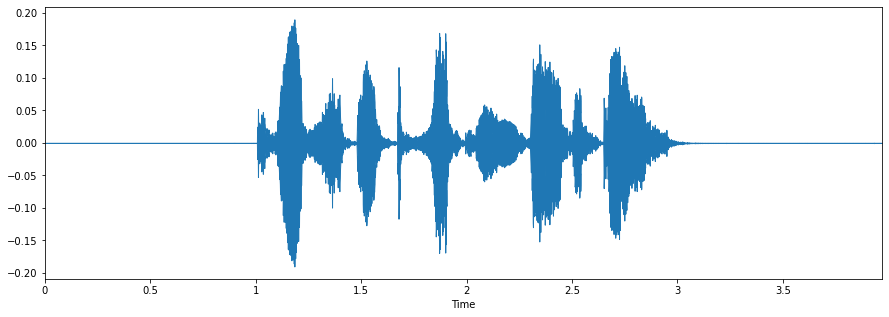

In [8]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [9]:
len(data)

87553

In [10]:
sampling_rate

22050

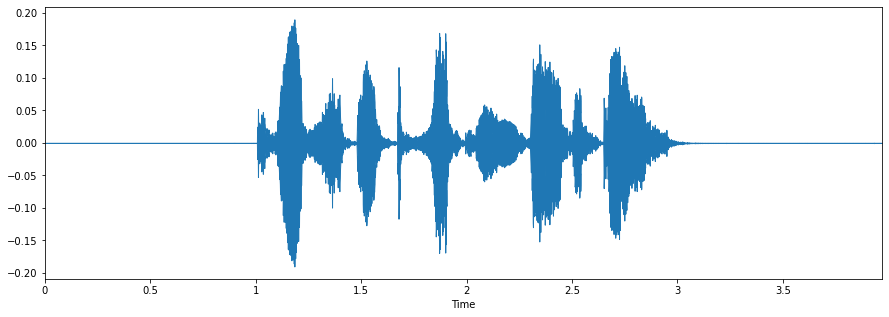

In [11]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [12]:
#Converting Dataset in CSV format
dataset_path = os.path.abspath('./Dataset')
destination_path = os.path.abspath('./')
# To shuffle the dataset instances/records
randomize = True
# for spliting dataset into training and testing dataset
split = 0.8
# Number of sample per second e.g. 16KHz
sampling_rate = 20000 
emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]\

In [13]:
!ls

audio001.wav	    happy001.wav	      SER_model.h5
Dataset		    img_data		      speech_emotion_recognition.ipynb
dataset_attr.csv    model.json		      surprise001.wav
demo_audio.wav	    Others		      Trained_Models
fear003.wav	    Predictions.csv	      utils
features_dataframe  PTT-20220412-WA0018.opus  Varun-WA0020.opus


In [14]:
# import required libraries
import os
import sys
import csv
import librosa
import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image

#from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
np.random.seed(42)

def create_meta_csv(dataset_path, destination_path):
    """Create a meta csv file given a dataset folder path of Audio.
    
    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of audios.
    The file will contain audios and their labels. This file can be then used to make
    train, test and val splits, randomize them and load few of them (a mini-batch) in memory
    as required. The file is saved in dataset_path folder if destination_path is not provided.
    
    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta file if None provided, it'll store file in dataset_path
    Returns:
        True (bool): Returns True if 'dataset_attr.csv' was created successfully else returns an exception
    """
    # Change dataset path accordingly
    DATASET_PATH = os.path.abspath(dataset_path)
    csv_path=os.path.join(destination_path, 'dataset_attr.csv')
    flist = []
    emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]
    for root, dirs, files in os.walk(DATASET_PATH, topdown=False):
        for name in files:
            if (name.endswith('.wav')): 
                fullName = os.path.join(root, name)
                flist.append(fullName)

    split_format = str('/') if sys.platform=='linux' else str('\\')
    
    filenames=[]
    for idx,file in enumerate(flist):
        filenames.append(file.split(split_format)) 
        # print(filenames[idx])
    types=[]
    for idx,path in enumerate(filenames):
        types.append((flist[idx],emotions.index(path[-2]))) ##second last location has emotion name

    with open(csv_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows([("path","label")])
        writer.writerows(types)
    f.close()
    # change destination_path to DATASET_PATH if destination_path is None 
    if destination_path == None:
        destination_path = DATASET_PATH
        # write out as dataset_attr.csv in destination_path directory
        # if no error
    return True

def create_and_load_meta_csv_df(dataset_path, destination_path, randomize=True, split=None):
    """Create a meta csv file given a dataset folder path of audios and loads it as a pandas dataframe.
    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of audios.
    The function will return pandas dataframes for the csv and also train and test splits if you specify a 
    fraction in split parameter.
    
    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta csv file
        randomize (bool, optional): Randomize the csv records. Defaults to True
        split (double, optional): Percentage of train records. Defaults to None
    Returns:
        dframe (pandas.Dataframe): Returns a single Dataframe for csv if split is none, else returns more two Dataframes for train and test splits.
        train_set (pandas.Dataframe): Returns a Dataframe of length (split) * len(dframe)
        test_set (pandas.Dataframe): Returns a Dataframe of length (1 - split) * len(dframe)
    """
    if create_meta_csv(dataset_path, destination_path=destination_path):
        dframe = pd.read_csv(os.path.join(destination_path, 'dataset_attr.csv'))

    # shuffle if randomize is True or if split specified and randomize is not specified 
    # so default behavior is split
    if randomize == True or (split != None and randomize == None):
        # shuffle the dataframe here
        dframe=dframe.sample(frac=1).reset_index(drop=True)
        pass

    if split != None:
        train_set, test_set = train_test_split(dframe, split)
        return dframe, train_set, test_set 
    
    return dframe

In [15]:
def train_test_split(dframe, split_ratio):
    """Splits the dataframe into train and test subset dataframes.
    Args:
        split_ration (float): Divides dframe into two splits.
    Returns:
        train_data (pandas.Dataframe): Returns a Dataframe of length (split_ratio) * len(dframe)
        test_data (pandas.Dataframe): Returns a Dataframe of length (1 - split_ratio) * len(dframe)
    """
    # divide into train and test dataframes
    train_data= dframe.iloc[:int((split_ratio) * len(dframe)), :]
    test_data= dframe.iloc[int((split_ratio) * len(dframe)):,:]
    test_data=test_data.reset_index(drop=True) #reset index for test data
    return train_data, test_data

In [16]:
# loading dataframes using dataset module 
df, train_df, test_df = create_and_load_meta_csv_df(dataset_path, destination_path, randomize, split)

In [17]:
print('Dataset samples  : ', len(df),"\nTraining Samples : ", len(train_df),"\ntesting Samples  : ", len(test_df))

Dataset samples  :  2559 
Training Samples :  2047 
testing Samples  :  512


In [18]:
#Data Visualization
df.head()

,path,label
0,/content/drive/MyDrive/Colab Notebooks/Emotion...,3
1,/content/drive/MyDrive/Colab Notebooks/Emotion...,2
2,/content/drive/MyDrive/Colab Notebooks/Emotion...,1
3,/content/drive/MyDrive/Colab Notebooks/Emotion...,5
4,/content/drive/MyDrive/Colab Notebooks/Emotion...,0


In [ ]:
print("Actual Audio : ", df['path'][0])
print("Labels       : ", df['label'][0])


Actual Audio :  /content/drive/MyDrive/Colab Notebooks/Emotion Speech Recognition/Dataset/happy/happy332.wav
Labels       :  3


In [ ]:
#Labels Assigned for emotions 
unique_labels = train_df.label.unique()
unique_labels.sort()
print("unique labels in Emtion dataset : ")
print(*unique_labels, sep=', ')
unique_labels_counts = train_df.label.value_counts(sort=False)
print("\n\nCount of unique labels in Emotion dataset : ")
print(*unique_labels_counts,sep=', ')

unique labels in Emtion dataset : 
0, 1, 2, 3, 4, 5, 6


Count of unique labels in Emtion dataset : 
338, 356, 193, 359, 348, 210, 244


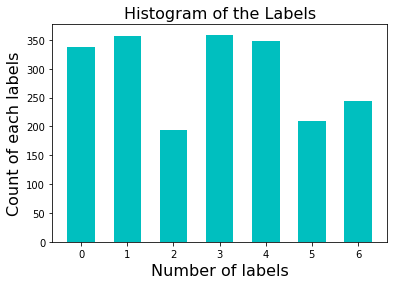

In [ ]:
# Histogram of the classes
plt.bar(unique_labels, unique_labels_counts,align = 'center', width=0.6, color = 'c')
plt.xlabel('Number of labels', fontsize=16)
plt.xticks(unique_labels)
plt.ylabel('Count of each labels', fontsize=16)
plt.title('Histogram of the Labels', fontsize=16)
plt.show()

# 5. Data Pre-Processing

### Getting the features of audio files using librosa

Calculating MFCC, Pitch, magnitude, Chroma features.

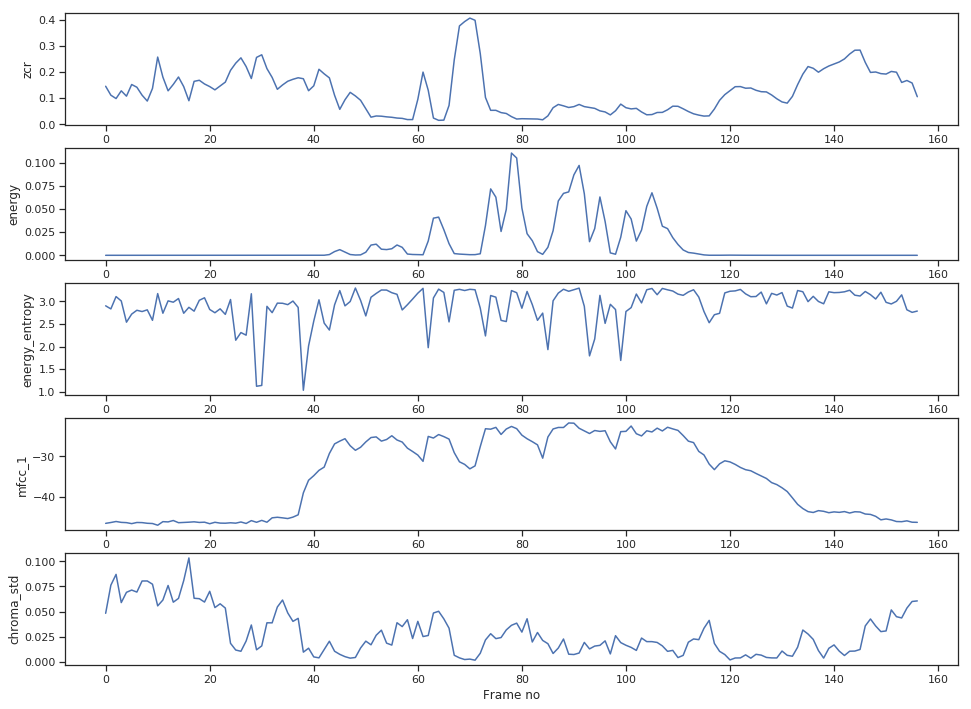

In [ ]:
#Image('feature_plots.png')
path="/content/drive/MyDrive/Colab Notebooks/Emotion Speech Recognition/utils/feature_plots.png"
display(Image.open(path))     

In [ ]:
from utils.feature_extraction import get_features_dataframe
from utils.feature_extraction import get_audio_features

In [ ]:

# trainfeatures, trainlabel = get_features_dataframe(train_df, sampling_rate)
# testfeatures, testlabel = get_features_dataframe(test_df, sampling_rate)

trainfeatures = pd.read_pickle('./features_dataframe/trainfeatures')
trainlabel = pd.read_pickle('./features_dataframe/trainlabel')
testfeatures = pd.read_pickle('./features_dataframe/testfeatures')
testlabel = pd.read_pickle('./features_dataframe/testlabel')

In [ ]:
trainfeatures.shape

(2044, 65)

In [ ]:
trainfeatures = trainfeatures.fillna(0)
testfeatures = testfeatures.fillna(0)

In [ ]:
# By using .ravel() : Converting 2D to 1D e.g. (512,1) -> (512,). To prevent DataConversionWarning

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel).ravel()
X_test = np.array(testfeatures)
y_test = np.array(testlabel).ravel()


In [ ]:
y_train[:5]

array([3, 2, 2, 0, 3])

In [ ]:
# One-Hot Encoding
lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
y_train[:5]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
#Changing dimension for CNN model
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape

(2044, 65, 1)

In [ ]:
#Model Creation
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 65, 256)           1536      
                                                                 
 activation (Activation)     (None, 65, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 128)           163968    
                                                                 
 activation_1 (Activation)   (None, 65, 128)           0         
                                                                 
 dropout (Dropout)           (None, 65, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 128)           0         
 )                                                               
                                                        

In [ ]:

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
#Training and Evaluation
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=370, validation_data=(x_testcnn, y_test))

Epoch 1/370
128/128 [==============================] - 8s 48ms/step - loss: 2.2484 - accuracy: 0.1747 - val_loss: 1.9056 - val_accuracy: 0.1816
Epoch 2/370
128/128 [==============================] - 6s 46ms/step - loss: 1.9288 - accuracy: 0.2118 - val_loss: 1.8507 - val_accuracy: 0.2168
Epoch 3/370
128/128 [==============================] - 6s 47ms/step - loss: 1.8587 - accuracy: 0.2495 - val_loss: 1.7550 - val_accuracy: 0.2773
Epoch 4/370
128/128 [==============================] - 6s 47ms/step - loss: 1.7882 - accuracy: 0.2798 - val_loss: 1.7279 - val_accuracy: 0.3047
Epoch 5/370
128/128 [==============================] - 6s 46ms/step - loss: 1.7401 - accuracy: 0.2994 - val_loss: 1.7163 - val_accuracy: 0.3027
Epoch 6/370
128/128 [==============================] - 6s 47ms/step - loss: 1.7173 - accuracy: 0.3165 - val_loss: 1.6543 - val_accuracy: 0.3359
Epoch 7/370
128/128 [==============================] - 6s 47ms/step - loss: 1.6660 - accuracy: 0.3361 - val_loss: 1.6401 - val_accuracy:

### Loss Vs Iterations

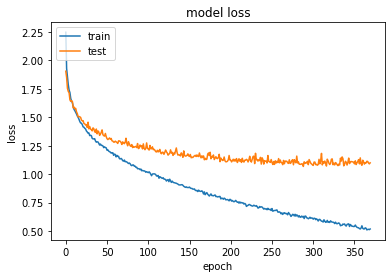

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Saving the model

In [ ]:
model_name = 'omar.h5'
save_dir = os.path.join(os.getcwd(), 'Trained_Models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Colab Notebooks/Emotion Speech Recognition/Trained_Models/omar.h5 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### Loading the model

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./Trained_Models/omar.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 59.96%


# 8. Test Set Prediction

### Predicting emotions on the test data

In [ ]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

16/16 [==============================] - 0s 18ms/step


In [ ]:
preds

array([[6.87346533e-02, 5.46058873e-03, 8.92662108e-01, ...,
        1.76258362e-03, 4.15789243e-03, 1.42493285e-02],
       [6.16686702e-01, 3.78654920e-03, 1.39574990e-01, ...,
        1.87942456e-03, 3.89693864e-02, 4.14151372e-03],
       [2.36488562e-02, 5.83370388e-01, 3.47745083e-02, ...,
        2.90546209e-01, 1.21318279e-02, 4.11798693e-02],
       ...,
       [2.39348202e-03, 4.86010879e-01, 4.54958379e-01, ...,
        1.73619874e-02, 1.08154444e-02, 9.47140343e-03],
       [1.79061051e-02, 1.53871762e-04, 1.50086015e-01, ...,
        2.91965000e-04, 5.37102401e-01, 9.99883850e-05],
       [3.95521596e-02, 2.32810616e-01, 2.24383399e-01, ...,
        1.24169551e-02, 1.51132857e-02, 4.40185726e-01]], dtype=float32)

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

array([2, 0, 1, 3, 3, 6, 3, 5, 3, 5, 2, 1, 0, 4, 4, 3, 2, 5, 5, 5, 2, 1,
       3, 4, 0, 0, 0, 2, 2, 3, 3, 4, 5, 3, 1, 3, 2, 3, 2, 3, 5, 6, 1, 0,
       5, 1, 1, 5, 1, 5, 1, 3, 2, 5, 5, 5, 2, 2, 2, 4, 4, 0, 5, 1, 0, 3,
       5, 2, 0, 3, 3, 2, 2, 2, 4, 5, 5, 6, 0, 1, 5, 1, 0, 2, 3, 3, 6, 2,
       2, 0, 3, 0, 4, 2, 2, 3, 1, 5, 1, 5, 2, 4, 5, 5, 3, 5, 5, 3, 6, 3,
       2, 0, 0, 3, 4, 5, 5, 5, 2, 1, 5, 3, 6, 3, 0, 5, 4, 2, 5, 1, 5, 5,
       1, 3, 4, 0, 3, 0, 1, 4, 0, 0, 1, 2, 0, 0, 1, 3, 4, 2, 5, 5, 4, 0,
       5, 5, 1, 0, 6, 1, 0, 5, 5, 5, 0, 0, 4, 4, 5, 1, 6, 5, 6, 2, 1, 1,
       2, 0, 5, 5, 1, 0, 4, 6, 2, 2, 2, 2, 1, 0, 5, 0, 4, 2, 4, 1, 0, 6,
       2, 2, 0, 2, 5, 4, 6, 3, 4, 5, 0, 4, 3, 3, 2, 2, 1, 1, 5, 2, 3, 4,
       5, 5, 0, 2, 4, 4, 1, 5, 5, 0, 5, 4, 4, 4, 0, 3, 4, 5, 1, 2, 6, 5,
       5, 2, 5, 5, 5, 2, 1, 0, 1, 4, 0, 5, 0, 1, 2, 1, 5, 4, 3, 3, 4, 4,
       2, 6, 5, 5, 2, 2, 5, 4, 2, 1, 4, 3, 2, 3, 0, 0, 2, 0, 5, 1, 1, 5,
       3, 4, 5, 1, 5, 3, 4, 5, 5, 0, 5, 5, 1, 0, 5,

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:


predictions = (lb.inverse_transform((abc)))

In [ ]:

preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,2
1,0
2,1
3,3
4,3
5,6
6,3
7,5
8,3
9,5


In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,2
1,0
2,1
3,2
4,3
5,6
6,6
7,5
8,3
9,5


In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[130:140]

,actualvalues,predictedvalues
130,1,5
131,5,5
132,1,1
133,3,3
134,4,4
135,0,0
136,3,3
137,0,0
138,1,1
139,6,4


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
0,81
1,60
2,83
3,85
4,53
5,97
6,53


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
0,75
1,66
2,97
3,71
4,57
5,118
6,28


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

# 9. Live Demonstration

#### The file 'demo_audio.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [ ]:
#demo_audio_path = './demo_audio.wav'
#ipd.Audio('./demo_audio.wav')PTT-20220412-WA0018.opus

#demo_audio_path = './Varun-WA0020.opus'
#ipd.Audio('./Varun-WA0020.opus')
demo_audio_path = './PTT-20220412-WA0018.opus'
ipd.Audio('./PTT-20220412-WA0018.opus')
#demo_audio_path = './audio001.wav'
#ipd.Audio('./audio001.wav')

NameError: ignored

In [ ]:
demo_mfcc, demo_pitch, demo_mag, demo_chrom = get_audio_features(demo_audio_path,sampling_rate)

mfcc = pd.Series(demo_mfcc)
pit = pd.Series(demo_pitch)
mag = pd.Series(demo_mag)
C = pd.Series(demo_chrom)
demo_audio_features = pd.concat([mfcc,pit,mag,C],ignore_index=True)

In [ ]:
demo_audio_features= np.expand_dims(demo_audio_features, axis=0)
demo_audio_features= np.expand_dims(demo_audio_features, axis=2)

In [ ]:
demo_audio_features.shape

(1, 65, 1)

In [ ]:

livepreds = loaded_model.predict(demo_audio_features, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 24ms/step


In [ ]:
livepreds

array([[0.0053392 , 0.03127664, 0.03234661, 0.00832191, 0.19149601,
        0.522146  , 0.2090737 ]], dtype=float32)

In [ ]:
# emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]
index = livepreds.argmax(axis=1).item()
index

5

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame()

In [ ]:

df.head(3)

""


In [ ]:
emotions[index]

'sad'